In [2]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

# Inport train and test datasets

In [ ]:
train = DataSet('redd.h5')
test = DataSet('redd.h5')

In [ ]:
#total = train.buildings[1].elec['total_energy']

In [3]:
building = 1

In [4]:
train.set_window(end="2011-04-30")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

# Select target appliances 

In [6]:
target_train_elec = train_elec.select_using_appliances(type=['microwave', 'dish washer'])
target_train_elec

MeterGroup(meters=
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

# Train the model

In [7]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [34]:
classifiers = {'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(target_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])' with 3 states
Runtime = 1.3694429397583008 seconds.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [35]:
appliance_labels = [m.label() for m in gt.columns.values]

In [36]:
gt.columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

In [37]:
predictions['FHMM'].head()

,Microwave,Dish washer
2011-04-30 00:00:00-04:00,1359.0,0.0
2011-04-30 00:02:00-04:00,1359.0,0.0
2011-04-30 00:04:00-04:00,1359.0,0.0
2011-04-30 00:06:00-04:00,111.0,1068.0
2011-04-30 00:08:00-04:00,111.0,47.0


# Plotting the predictions against the actual usage

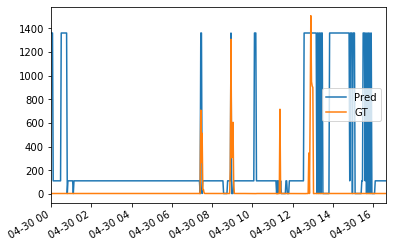

In [70]:
predictions['FHMM']['Microwave'].head(500).plot(label="Pred")
gt['Microwave'].head(500).plot(label="GT")

#predictions['FHMM']['Microwave'].plot(label="Pred")
#gt['Microwave'].plot(label="GT")
plt.legend()

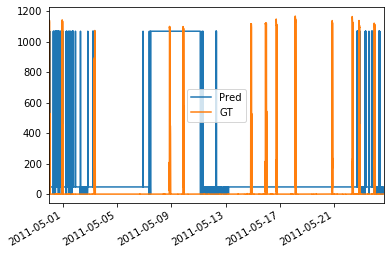

In [69]:
#predictions['FHMM']['Dish washer'].head(300).plot(label="Pred")
#gt['Dish washer'].head(300).plot(label="GT")

predictions['FHMM']['Dish washer'].plot(label="Pred")
gt['Dish washer'].plot(label="GT")
plt.legend()

In [18]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse

,FHMM
Microwave,556.613013
Dish washer,452.217736


In [48]:
rmse = nilmtk.utils.compute_rmse(gt, predictions['FHMM'])
rmse

Microwave      556.613013
Dish washer    452.217736
dtype: float64

In [60]:
type(gt['Microwave'])

pandas.core.series.Series

In [62]:
from nilmtk import losses
mae_fhmm_micro = losses.mae(gt['Microwave'], predictions['FHMM']['Microwave'])
mae_fhmm_micro

312.746006671806

In [63]:
mae_fhmm_dish = losses.mae(gt['Dish washer'], predictions['FHMM']['Dish washer'])
mae_fhmm_dish

226.7228803628854

In [66]:
f1_fhmm_dish = losses.f1score(gt['Dish washer'], predictions['FHMM']['Dish washer'])
f1_fhmm_dish

0.0841385104723039

In [67]:
f1_fhmm_micro = losses.f1score(gt['Microwave'], predictions['FHMM']['Microwave'])
f1_fhmm_micro


0.038128249566724434